In [1]:
#NOTE: use python env acmil in ACMIL folder
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
warnings.filterwarnings("ignore")
%matplotlib inline

In [13]:
####################################
######      USERINPUT       ########
####################################
cohort = "TEST" #TEST， TMA
s_outcome = "ROC_AUC" #PR_AUC

proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/z_old_mutation_prediction_results/pred_out02122025/'
perf_dir_retccl = proj_dir + 'retccl' + '/TrainOL100_TestOL0_TFT0.9/'
perf_dir_uni1 = proj_dir + 'uni1' + '/TrainOL100_TestOL0_TFT0.9/'
perf_dir_uni2 = proj_dir + 'uni2' + '/TrainOL100_TestOL0_TFT0.9/'


In [14]:
perf_df_retccl = pd.read_csv(perf_dir_retccl + "ALL_" + cohort + "_perf.csv")
perf_df_retccl = perf_df_retccl.drop('Unnamed: 0', axis=1)
perf_df_retccl['METHOD'] ='retccl'
perf_df_uni1 = pd.read_csv(perf_dir_uni1+ "ALL_" + cohort + "_perf.csv")
perf_df_uni1 = perf_df_uni1.drop('Unnamed: 0', axis=1)
perf_df_uni1['METHOD'] ='uni'
perf_df_uni2 = pd.read_csv(perf_dir_uni2+ "ALL_" + cohort + "_perf.csv")
perf_df_uni2 = perf_df_uni2.drop('Unnamed: 0', axis=1)
perf_df_uni2['METHOD'] ='uni2'

In [15]:
all_perf_df = pd.concat([perf_df_retccl, perf_df_uni1, perf_df_uni2])

In [26]:
# Create scatter plot
plot_df = all_perf_df.copy()
plot_df = plot_df.loc[plot_df['OUTCOME'] == 'AVERAGE']
plot_df = plot_df.loc[plot_df['N_TOKENS'] == 3]

,OUTCOME,N_TOKENS,ROC_AUC,ACC,F1,F2,F3,Recall,Precision,Specificity,...,ROC_AUC_STD,ACC_STD,F1_STD,F2_STD,F3_STD,Recall_STD,Precision_STD,Specificity_STD,PR_AUC_STD,METHOD
57,AVERAGE,3,0.654286,0.740000,0.321429,0.350000,0.362857,0.380357,0.298929,0.819286,...,0.080841,0.040125,0.108807,0.120519,0.128263,0.138283,0.107000,0.031631,0.095868,retccl
57,AVERAGE,3,0.692500,0.748214,0.330357,0.360000,0.375714,0.397857,0.308929,0.828214,...,0.094247,0.050317,0.124691,0.138325,0.146502,0.160618,0.119436,0.032638,0.126715,uni
57,AVERAGE,3,0.726786,0.766786,0.377143,0.407143,0.423571,0.443214,0.355714,0.841071,...,0.096896,0.052000,0.130538,0.136327,0.139407,0.149606,0.132427,0.033791,0.140597,uni2


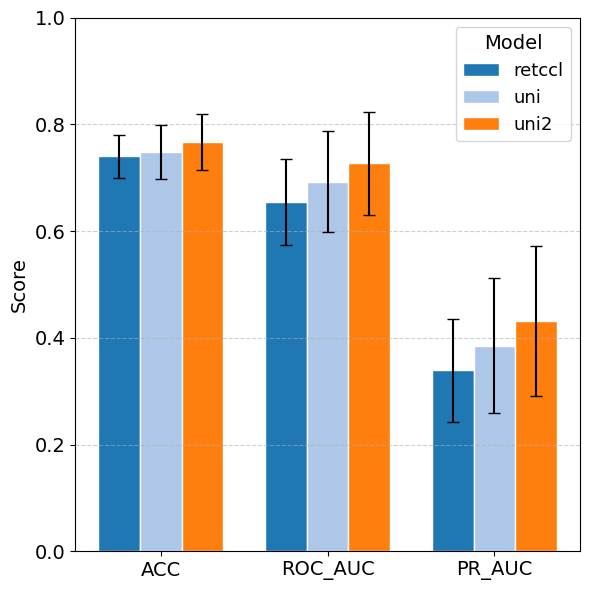

In [52]:
# Metric names and corresponding std columns
metrics = ["ACC","ROC_AUC", "PR_AUC"]
std_cols = [f"{m}_STD" for m in metrics]

# Melt for plotting
melted_avg = plot_df[["METHOD"] + metrics].melt(id_vars="METHOD", var_name="Metric", value_name="Score")
melted_std = plot_df[["METHOD"] + std_cols].rename(columns={col: col.replace("_STD", "") for col in std_cols}).melt(id_vars="METHOD", var_name="Metric", value_name="STD")

# Merge mean and std
df_plot = pd.merge(melted_avg, melted_std, on=["METHOD", "Metric"])

# Use a color palette (e.g., tab10, Set2, viridis)
palette = plt.get_cmap("tab20")
method_colors = {method: palette(i) for i, method in enumerate(plot_df["METHOD"].unique())}

# Plotting
plt.figure(figsize=(6, 6))
ax = plt.subplot()

methods = plot_df["METHOD"].unique()
x = np.arange(len(metrics))
width = 0.25

# Plot each method with error bars
for i, method in enumerate(methods):
    subset = df_plot[df_plot["METHOD"] == method]
    ax.bar(x + i * width, subset["Score"], width=width, yerr=subset["STD"], capsize=4, label=method,color=method_colors[method], edgecolor="white")

# Customization
ax.set_xticks(x + width)
ax.set_xticklabels(metrics, rotation=0, fontsize = 14)
ax.set_ylabel("Score", fontsize=14)
#ax.set_title("Performance by Feature Extraction Foundation Models")
ax.legend(title="Model",  title_fontsize=14, fontsize=13)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_ylim(0, 1)
ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()
plt.show()

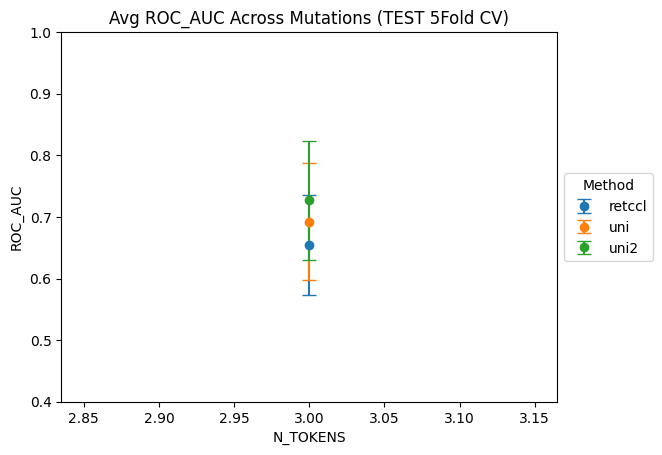

In [21]:
tab10 = plt.get_cmap('tab10')
# Define custom colors for each group
colors = {
    'retccl': tab10(0),       # First color in tab10
    'uni': tab10(1),  # Second color in tab10
    'uni2': tab10(2),       # Third color in tab10
}

# # Create scatter plot with grouping
# groups = plot_df.groupby('METHOD')
# for name, group in groups:
#     plt.scatter(group['N_TOKENS'], group[s_outcome], label=name, color=colors.get(name, 'black'))
#     plt.plot(group['N_TOKENS'], group[s_outcome], color=colors.get(name, 'black'))

# Create scatter plot with grouping and error bars
groups = plot_df.groupby('METHOD')
for name, group in groups:
    plt.errorbar(group['N_TOKENS'], group[s_outcome], yerr=group['ROC_AUC_STD'], fmt='o', label=name, color=colors.get(name, 'black'), capsize=5)
    plt.plot(group['N_TOKENS'], group[s_outcome], color=colors.get(name, 'black'))
    
# Add title and labels
plt.title('Avg ' + s_outcome + ' Across Mutations' + ' (' + cohort +  ' 5Fold CV)')
plt.xlabel('N_TOKENS')
plt.ylabel(s_outcome)
plt.ylim(0.4, 1)
plt.legend(title='Method', loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig(perf_dir + s_outcome + '_' + cohort + '_scatter_plot.png', bbox_inches='tight')
# Show plot
plt.show()

In [8]:
#Get patient-level prediction

In [61]:
#Final best
corhort = 'TMA'
perf_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02122025/uni2/TrainOL100_TestOL0_TFT0.9/'
df = pd.read_csv(perf_dir + 'ALL_' + corhort + '_perf.csv')

# List of columns to concatenate
columns = ['ROC_AUC', 'ACC', 'F1', 'F2', 'F3', 'Recall', 'Precision', 'Specificity', 'PR_AUC']

# Concatenate each column with its corresponding STD column
for col in columns:
    df[col + '_Combined'] = df[col].round(2).astype(str) + ' ± ' + df[col + '_STD'].round(2).astype(str)

df.to_csv(perf_dir  + "Reformated_ALL_" + corhort + "_perf.csv",index = True)